## Reading the Data

In [1]:
#required libraries
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

In [2]:
sns.set(rc={'figure.figsize':(10,10)});

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,NaN,05:43.3,0,35.427,0,43.313,0,28.8,07:02.0,22:02.0,05:43.3,00:35.4,00:43.3,SB,05:14.7,NaN,JR,NaN,Location 2,Free Practice 2
1,10,1,2,87,2,NaN,25.674,2,33.399,2,41.922,2,120.5,08:43.0,23:43.0,00:25.7,00:33.4,00:41.9,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
2,10,1,3,73,0,B,28.129,0,34.091,0,57.248,0,101.9,10:42.5,25:42.5,00:28.1,00:34.1,00:57.2,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
3,11,1,1,73,0,NaN,01:05.0,0,38.416,0,56.833,0,75.9,02:40.2,17:40.2,01:05.0,00:38.4,00:56.8,LGRA,00:33.0,NaN,AD,NaN,Location 2,Free Practice 2
4,11,1,2,73,0,NaN,28.013,0,36.743,0,44.716,0,111.2,04:29.7,19:29.7,00:28.0,00:36.7,00:44.7,LGRA,NaN,NaN,AD,NaN,Location 2,Free Practice 2


In [4]:
#reading the weather data
train_weather = pd.read_csv('train_weather.csv')
test_weather = pd.read_csv('test_weather.csv')
train_weather.head()

,TIME_UTC_SECONDS,TIME_UTC_STR,AIR_TEMP,TRACK_TEMP,HUMIDITY,PRESSURE,WIND_SPEED,WIND_DIRECTION,RAIN,LOCATION,EVENT
0,1618042506,10/04/21 8:15,15,18.4,60,1018.05,2.12187,165,-1,Location 2,Free Practice 2
1,1618042567,10/04/21 8:16,15.0556,18.4,60,1018.12,1.06093,177,-1,Location 2,Free Practice 2
2,1618042632,10/04/21 8:17,15.0556,18.5,60,1018.12,2.12187,157,-1,Location 2,Free Practice 2
3,1618042697,10/04/21 8:18,15.0556,18.5,60,1018.08,2.12187,163,-1,Location 2,Free Practice 2
4,1618042762,10/04/21 8:19,15.1111,18.5,60,1018.15,3.1828,149,-1,Location 2,Free Practice 2


In [5]:
print("Number of Training Instances: ", train.shape[0])
print("Number of Test Instances: ", test.shape[0])
print("\nNumber of Training Weather Instances: ",train_weather.shape[0])
print("Number of Test Weather Instances: ",test_weather.shape[0])
print("\nTotal Number of Features in Train Data: ", train.shape[1] + train_weather.shape[1] -2)
print("Total Number of Features in Test Data: ",   test.shape[1] + test_weather.shape[1] -2)
print("\nTarget Variable: LAP_TIME")

Number of Training Instances:  10276
Number of Test Instances:  420

Number of Training Weather Instances:  914
Number of Test Weather Instances:  167

Total Number of Features in Train Data:  34
Total Number of Features in Test Data:  34

Target Variable: LAP_TIME


In [6]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TIME_UTC_SECONDS  914 non-null    int64 
 1   TIME_UTC_STR      914 non-null    object
 2   AIR_TEMP          914 non-null    object
 3   TRACK_TEMP        914 non-null    object
 4   HUMIDITY          914 non-null    object
 5   PRESSURE          914 non-null    object
 6   WIND_SPEED        914 non-null    object
 7   WIND_DIRECTION    914 non-null    int64 
 8   RAIN              914 non-null    object
 9   LOCATION          914 non-null    object
 10  EVENT             914 non-null    object
dtypes: int64(2), object(9)
memory usage: 78.7+ KB


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10276 entries, 0 to 10275
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NUMBER                        10276 non-null  int64  
 1    DRIVER_NUMBER                10276 non-null  int64  
 2    LAP_NUMBER                   10276 non-null  int64  
 3   LAP_TIME                      10276 non-null  int64  
 4    LAP_IMPROVEMENT              10276 non-null  int64  
 5    CROSSING_FINISH_LINE_IN_PIT  1234 non-null   object 
 6    S1                           10272 non-null  object 
 7    S1_IMPROVEMENT               10276 non-null  int64  
 8    S2                           10268 non-null  object 
 9    S2_IMPROVEMENT               10276 non-null  int64  
 10   S3                           10242 non-null  object 
 11   S3_IMPROVEMENT               10276 non-null  int64  
 12   KPH                          10246 non-null  float64
 13   

In [8]:
#missing values
print("Train data Missing Values: \n", train.isna().sum()[train.isna().sum()>0])
print("\nTest data Missing Values: \n",test.isna().sum()[test.isna().sum()>0][1:])
print("\nTrain Weather data Missing Values: \n", train_weather.isna().sum()[train_weather.isna().sum()>0])
print("\nTest Weather data Missing Values: \n", test_weather.isna().sum()[test_weather.isna().sum()>0])

Train data Missing Values: 
  CROSSING_FINISH_LINE_IN_PIT    9042
 S1                                4
 S2                                8
 S3                               34
 KPH                              30
S1_LARGE                           4
S2_LARGE                           8
S3_LARGE                          34
PIT_TIME                        8378
GROUP                           9768
POWER                           7373
dtype: int64

Test data Missing Values: 
  CROSSING_FINISH_LINE_IN_PIT    404
 S3                               2
 KPH                              2
S3_LARGE                          2
PIT_TIME                        265
GROUP                            29
POWER                           111
dtype: int64

Train Weather data Missing Values: 
 Series([], dtype: int64)

Test Weather data Missing Values: 
 Series([], dtype: int64)


The dataset contains datetime, numerical and categorical types of data. Both training & test weather dataset do not have any missing values, however the `train` & `test` data frames contains a lot of missing values in the `CROSSING_FINISH_LINE_IN_PIT`, `PIT_TIME`, `GROUP`, `POWER`columns and few null values in some features relating to sector and speed.

## Cleaning the Data

In [9]:
train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]
train_weather.columns = [col.strip() for col in train_weather.columns]
test_weather.columns = [col.strip() for col in test_weather.columns]
#renaming events column
test_weather.rename(columns={'EVENTS': 'EVENT'}, inplace=True)

**Weather Data**

*Let's look at the numerical columns like `AIR_TEMP`, `TRACK_TEMP`, `HUMIDITY`, `PRESSURE` and `WIND_SPEED`.*


In [10]:
#merging the train & test data frames
wdf = pd.concat([train_weather,test_weather], axis=0)
wdf = wdf.reset_index(drop=True)
wdf.shape

(1081, 11)

In [11]:
print("Unique values in weather data: ")
for nc in ['AIR_TEMP','TRACK_TEMP','HUMIDITY','PRESSURE','WIND_SPEED']:
  print(nc, ": \n", wdf[nc].unique()[:15])

Unique values in weather data: 
AIR_TEMP : 
 ['15' '15.0556' '15.1111' '14.9444' '14.8889' '14.8333' '15.3333'
 '15.2778' '15.2222' '15.1667' '9.77778' '9.83333' '9.94445' '10'
 '10.0556']
TRACK_TEMP : 
 ['18.4' '18.5' '18.6' '18.7' '18.8' '18.9' '19' '19.1' '19.2' '19.3'
 '19.5' '19.6' '19.7' '19.9' '20']
HUMIDITY : 
 ['60' '61' '62' '63' '68' '67' '66' '65' '64' '30' '32' '31' '29' '87'
 '92']
PRESSURE : 
 ['1018.05' '1018.12' '1018.08' '1018.15' '1018.25' '1018.22' '1018.29'
 '1018.35' '1018.39' '1018.19' '1017.98' '1017.58' '1017.64' '1017.61'
 '1017.68']
WIND_SPEED : 
 ['2.12187' '1.06093' '3.1828' '6.3656' '4.24374' '7.42654' '5.30467' '0'
 '8.48747' '10.6093' '1,06' '11,61' '11,59' '21,6' '14,56']


We have some inconsistent values in these columns. Some of the values in the `PRESSURE` column also seem to be represented in different units, so let's drop the column.

In [12]:
wdf['AIR_TEMP'] = wdf['AIR_TEMP'].str.replace(',', '.')
wdf['AIR_TEMP'] = wdf['AIR_TEMP'].str[:4]

wdf['TRACK_TEMP'] = wdf['TRACK_TEMP'].str.replace(',','.')

In [13]:
wdf['WIND_SPEED'] = wdf['WIND_SPEED'].str.replace(',','.',1)
wdf['WIND_SPEED'] = wdf['WIND_SPEED'].str.replace(',','')
wdf['WIND_SPEED'] = wdf['WIND_SPEED'].str[:4]

wdf['HUMIDITY'] = wdf['HUMIDITY'].str.replace(',','.')

In [14]:
#converting data type from object to numeric
wdf = wdf.astype({"AIR_TEMP": float, "TRACK_TEMP": float, "WIND_SPEED":float, 
                  "HUMIDITY": float})
wdf['AIR_TEMP'] = wdf['AIR_TEMP'].round(2)
wdf['HUMIDITY'] = wdf['HUMIDITY'].round()
wdf.describe()

,TIME_UTC_SECONDS,AIR_TEMP,TRACK_TEMP,HUMIDITY,WIND_SPEED,WIND_DIRECTION
count,1.081000e+03,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000
mean,1.622303e+09,14.508770,23.418779,68.081406,5.383617,182.490287
std,4.850934e+06,7.876356,8.534886,17.784222,8.772248,113.542650
min,1.614266e+09,1.380000,10.200000,29.000000,0.000000,1.000000
25%,1.618119e+09,10.700000,17.100000,61.000000,1.060000,71.000000
50%,1.624108e+09,15.300000,23.200000,70.000000,2.120000,175.000000
75%,1.627057e+09,20.500000,30.300000,81.000000,5.300000,297.000000
max,1.629021e+09,30.000000,48.100000,95.000000,63.600000,360.000000


The average humidity is around 68% with an average wind speed of 5kph. The mean track temperature is much higher than the air temperature. *Let's now look at the datetime column `TIME_IN_UTC_STR`.*

In [15]:
#extracting the month and hour of the day from the column
hour=[]
month=[]
for i in wdf['TIME_UTC_STR']:
  temp = datetime.datetime.strptime(i,  '%d/%m/%y  %H:%M')
  hour.append(temp.hour)
  month.append(temp.month)
wdf['TIME_HOUR'] = hour
wdf['TIME_MONTH'] = month

print("Hour:\n", wdf.TIME_HOUR.unique())
print("Month:\n", wdf.TIME_MONTH.unique())
for cc in ['RAIN','LOCATION','EVENT']:
  print(cc, ": \n", wdf[cc].unique())

Hour:
 [ 8  9 10  6 13 11 17 14  7  5 16 15 12]
Month:
 [4 2 7 6 5 8]
RAIN : 
 ['-1' '0' '0,01' '0,25' '0,03' '0,02' 0]
LOCATION : 
 ['Location 2' 'Location 1' 'Location 3' 'Location 7' 'Location 5'
 'Location 6' 'Location 4' 'Location 8']
EVENT : 
 ['Free Practice 2' 'Qualifying Group 1' 'Free Practice 1'
 'Qualifying Group 2' 'Qualifying Group 4' 'Qualifying Group 3'
 'Free Practice 3']


We have the weather data for the month of Febraury and from the April month to August. The time ranges from 5 to 17 hours. There are four Qualifying Groups and three Free Practice events along with the eight different locations.



In [16]:
wdf[['LOCATION','EVENT']] = wdf[['LOCATION','EVENT']]
wdf = wdf.drop(columns = ['RAIN','TIME_UTC_SECONDS', 'TIME_UTC_STR','PRESSURE'], axis=1)
wdf.columns

Index(['AIR_TEMP', 'TRACK_TEMP', 'HUMIDITY', 'WIND_SPEED', 'WIND_DIRECTION',
       'LOCATION', 'EVENT', 'TIME_HOUR', 'TIME_MONTH'],
      dtype='object')

**Training & Test Data**

In [17]:
#merging train & test data frames
df = pd.concat([train, test], axis=0)
df.shape

(10696, 25)

*Let's first look at the columns with missing values, `CROSSING_FINISH_LINE_IN_PIT`, `S1`, `S2`, `S3`, `S1_LARGE`, `S2_LARGE`, `S3_LARGE`, `KPH`, `PIT_TIME`, `GROUP`, `POWER`. Since the data in `S1_LARGE`, `S2_LARGE`, `S3_LARGE` columns is also represented in different format in `S1`, `S2`, `S3`, we'll be dropping these columns.*

In [18]:
df = df.drop(['S1','S2','S3'], axis=1)

In [19]:
#number of unique values
df.nunique()

NUMBER                           24
DRIVER_NUMBER                     1
LAP_NUMBER                       31
LAP_TIME                        161
LAP_IMPROVEMENT                   4
CROSSING_FINISH_LINE_IN_PIT       1
S1_IMPROVEMENT                    4
S2_IMPROVEMENT                    4
S3_IMPROVEMENT                    4
KPH                            1258
ELAPSED                        8541
HOUR                           9145
S1_LARGE                       1437
S2_LARGE                        476
S3_LARGE                        904
DRIVER_NAME                      24
PIT_TIME                       1562
GROUP                             4
TEAM                             23
POWER                             2
LOCATION                          8
EVENT                             7
dtype: int64

In [20]:
df[df.S1_LARGE.isna()]

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1_IMPROVEMENT,S2_IMPROVEMENT,S3_IMPROVEMENT,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
5819,28,1,7,89.0,0,B,0,0,0,119.8,17:14.2,32:14.2,NaN,NaN,00:32.5,M¬úNT,NaN,NaN,BMWl,NaN,Location 3,Free Practice 2
6051,10,1,9,86.0,0,NaN,0,0,0,131.0,17:20.1,37:20.1,NaN,NaN,00:28.1,SB,NaN,NaN,JR,NaN,Location 3,Free Practice 1
8050,13,1,19,73.0,0,B,0,0,0,NaN,29:21.4,0:00,NaN,NaN,NaN,ACO,NaN,NaN,DSo,NaN,Location 6,Free Practice 1
8141,25,1,19,94.0,0,B,0,0,0,NaN,33:10.0,0:00,NaN,NaN,NaN,JVER,NaN,NaN,DS¬â,NaN,Location 6,Free Practice 1


*Let's also remove the four rows with missing values in `S1_LARGE` in training dataset.*

In [21]:
df = df.dropna(axis=0, subset=['S1_LARGE'])
df = df.dropna(axis=0, subset=['S2_LARGE'])

In [22]:
df['PT'] = df['PIT_TIME'].isna().map({True:0,False:1})
df['PT'].value_counts()

0    8635
1    2053
Name: PT, dtype: int64

In [23]:
print(round(df.PIT_TIME.isna().sum()/df.shape[0]*100))

81


The `PIT_TIME` column has 81% null values, so we will discard the feature along with `CROSSING_FINISH_LINE_IN_PIT`,`POWER` & `GROUP`. The `ELAPSED` time equals to the total of the time taken to complete the three sectors for the driver. Let's convert these time columns in the format of seconds.

In [24]:
def convert2sec(i):
  t = i.split(':')
  hr = int(t[0])
  min = int(t[1].split('.')[0])
  sec = int(t[1].split('.')[1])
  t_seconds = (hr*60*60) + (min*60) + sec
  return t_seconds

def convert2hms(sec):
  hr =  sec // 3600
  sec = sec % 3600
  min, sec = sec // 60, sec % 60
  t = str(hr) +':'+ str(min) +'.'+ str(sec)
  return t

In [25]:
#filling missing values in S3_LARGE
li=[]
for i in df['S3_LARGE'][df['S3_LARGE'].isna()].index:
  et = convert2sec(df.iloc[i]['ELAPSED'])
  s1 = convert2sec(df.iloc[i]['S1_LARGE'])
  s2 = convert2sec(df.iloc[i]['S2_LARGE'])
  s3 = et - (s1 + s2)
  
  s3 = convert2hms(s3)
  li.append(s3)

df.loc[df['S3_LARGE'].isna(),'S3_LARGE'] = li
df[df.S3_LARGE == '44:33.57']

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1_IMPROVEMENT,S2_IMPROVEMENT,S3_IMPROVEMENT,KPH,ELAPSED,HOUR,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT,PT
2479,33,1,21,89.0,0,B,0,0,0,NaN,45:37.0,0:00,00:27.3,00:36.0,44:33.57,RR,NaN,NaN,AR,NaN,Location 6,Free Practice 3,0


In [26]:
df['elapsed_sec'] = df['ELAPSED'].apply(lambda x: convert2sec(x))
df['s1_sec'] = df['S1_LARGE'].apply(lambda x: convert2sec(x))
df['s2_sec'] = df['S2_LARGE'].apply(lambda x: convert2sec(x))
df['s3_sec'] = df['S3_LARGE'].apply(lambda x: convert2sec(x))

df =df.reset_index(drop=True)

In [27]:
#fill the missing values
kph = []
for i in df[df.KPH.isna()].index:
  name = df.loc[i, 'DRIVER_NAME']
  speed = df[df.DRIVER_NAME == name]['KPH'].mean()
  kph.append(round(speed,1))

df.loc[df.KPH.isna(),'KPH'] = kph
df.KPH.isna().sum()

0

In [28]:
df['mps'] = df['KPH'] / 3.6
df['mps'] = df['mps'].round(2)

In [29]:
df_num = df.groupby(['NUMBER'])['mps'].agg(['mean','min','max'])
df['num_mean'] = 0
df['num_min'] = 0
df['num_max'] = 0
numbers = list(df_num.index)
for i in numbers:
  df.loc[df['NUMBER']== i, 'num_mean'] = df_num['mean']
  df.loc[df['NUMBER'] == i, 'num_min'] = df_num['min']
  df.loc[df['NUMBER'] == i, 'num_max'] = df_num['max']

In [30]:
df.drop(columns=['DRIVER_NUMBER','KPH', 'ELAPSED', 'HOUR', 'S1_LARGE', 'S2_LARGE', 'S3_LARGE', 'DRIVER_NAME', 
                 'PIT_TIME','CROSSING_FINISH_LINE_IN_PIT','POWER','GROUP'],axis=1,inplace=True)
df.columns

Index(['NUMBER', 'LAP_NUMBER', 'LAP_TIME', 'LAP_IMPROVEMENT', 'S1_IMPROVEMENT',
       'S2_IMPROVEMENT', 'S3_IMPROVEMENT', 'TEAM', 'LOCATION', 'EVENT', 'PT',
       'elapsed_sec', 's1_sec', 's2_sec', 's3_sec', 'mps', 'num_mean',
       'num_min', 'num_max'],
      dtype='object')

## Exploratory Data Analysis & Visualization

*Let's further analyze the datasets and visualize the distribution of the numerical and categorical columns.*

In [31]:
#creating new columns by binning
bins = [0,30,60,90,120]
labels=['Less than 30','30-60','60-90','Above 90']
wdf['HUMIDITY_BIN'] = pd.cut(wdf['HUMIDITY'], bins=bins, labels=labels, include_lowest=True)

bins = [ 0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5, 360 ]
labels = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW','WSW', 'W', 'WNW', 'NW', 'NNW']
wdf['WIND_DIRECTION_BIN'] = pd.cut(wdf['WIND_DIRECTION'], bins=bins, labels=labels, include_lowest=True)

LOCATION

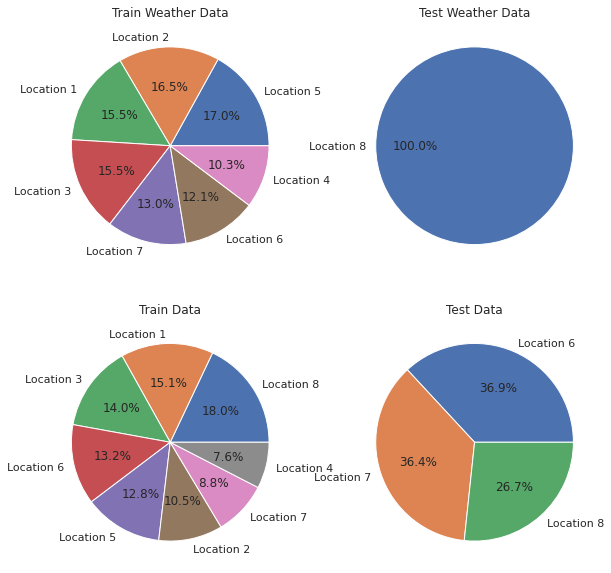

In [32]:
trainWLoc = train_weather.LOCATION.value_counts()
testWLoc = test_weather.LOCATION.value_counts()
trainLoc = train.LOCATION.value_counts()
testLoc = test.LOCATION.value_counts()
dataLoc = ['Train Weather Data', 'Test Weather Data','Train Data','Test Data']
num_plots = 4
total_cols = 2
total_rows = num_plots // total_cols
fig, axes = plt.subplots(nrows=total_rows, ncols=total_cols,
                         figsize=(5*total_cols, 5*total_rows))

for idx, feature in enumerate([trainWLoc, testWLoc, trainLoc, testLoc]):

    row = idx // total_cols
    pos = idx % total_cols
    ax = axes[row][pos]
    ax.pie(feature,  labels=feature.index, 
            autopct='%1.1f%%');
    ax.title.set_text(dataLoc[idx]);


EVENT

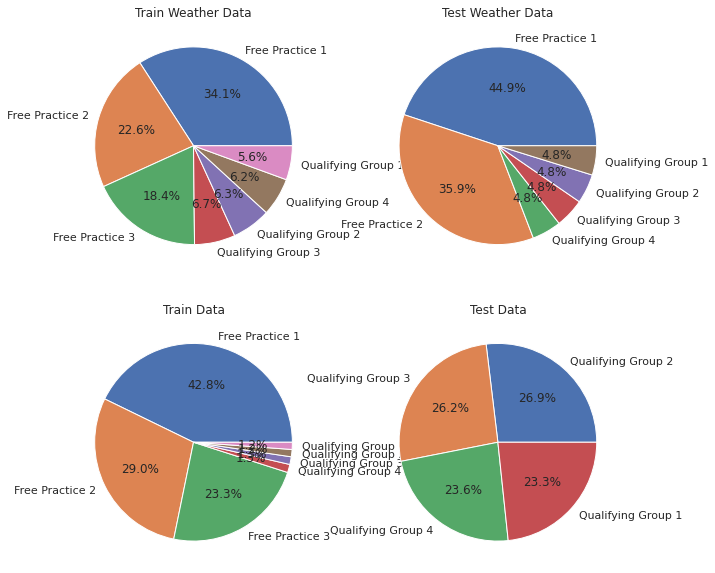

In [34]:
trainWEvent = train_weather.EVENT.value_counts()
testWEvent = test_weather.EVENT.value_counts()
trainEvent = train.EVENT.value_counts()
testEvent = test.EVENT.value_counts()
dataLoc = ['Train Weather Data', 'Test Weather Data','Train Data','Test Data']
num_plots = 4
total_cols = 2
total_rows = num_plots // total_cols
fig, axes = plt.subplots(nrows=total_rows, ncols=total_cols,
                         figsize=(5*total_cols, 5*total_rows))

for idx, feature in enumerate([trainWEvent, testWEvent, trainEvent, testEvent]):

    row = idx // total_cols
    pos = idx % total_cols
    ax = axes[row][pos]
    ax.pie(feature,  labels=feature.index, 
            autopct='%1.1f%%');
    ax.title.set_text(dataLoc[idx]);

**Weather Data**

TIME

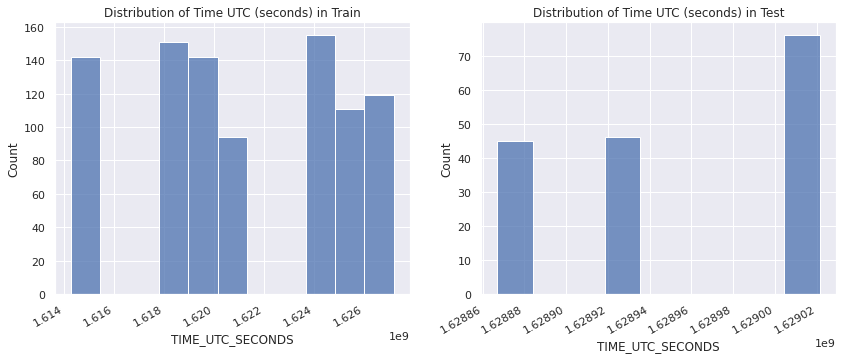

In [35]:

fig,axes = plt.subplots(1,2, figsize = (14,5));

fig = sns.histplot(x = train_weather['TIME_UTC_SECONDS'], ax = axes[0]);
axes[0].title.set_text('Distribution of Time UTC (seconds) in Train');

fig = sns.histplot(x = test_weather['TIME_UTC_SECONDS'], ax = axes[1]);
axes[1].title.set_text('Distribution of Time UTC (seconds) in Test');

for label in axes[0].get_xmajorticklabels() + axes[1].get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
plt.show();

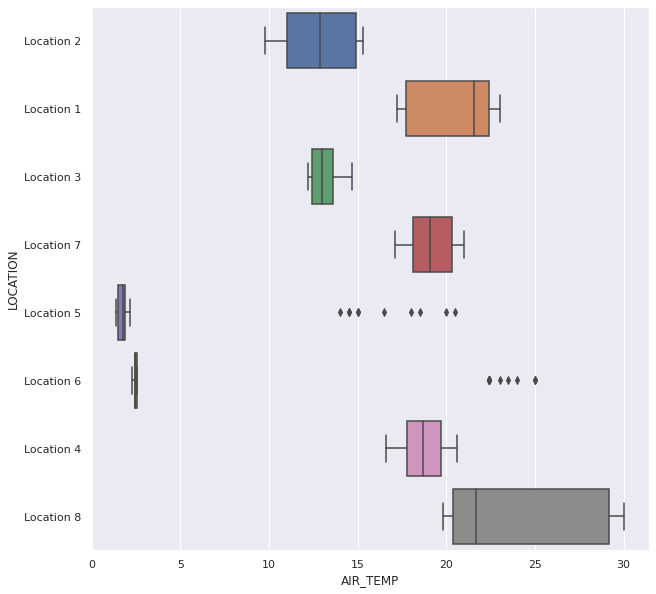

In [36]:
sns.boxplot(data=wdf, x="AIR_TEMP", y='LOCATION');

WIND ROSE CHART

In [37]:
fig = px.bar_polar(wdf, r="WIND_SPEED", theta="WIND_DIRECTION_BIN",
                   color="HUMIDITY_BIN", template="plotly_dark",
                   color_discrete_sequence= px.colors.qualitative.Bold_r)
fig.show()

AIR TEMPERATURE

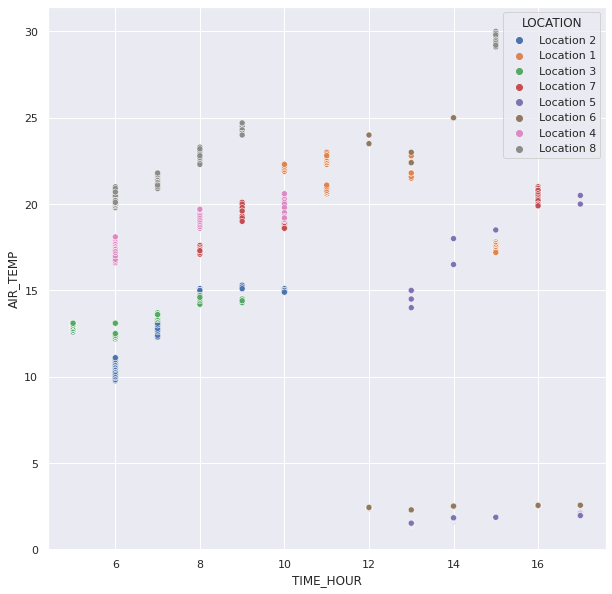

In [38]:
sns.scatterplot(x = wdf['TIME_HOUR'], y = wdf['AIR_TEMP'], hue=wdf['LOCATION']);

## Baseline Model

In [39]:
left=wdf.groupby(['LOCATION']).agg(['mean','median','min','max'])
left

AIR_TEMP                      ... TIME_MONTH               
                 mean median    min   max  ...       mean median min max
LOCATION                                   ...                          
Location 1  20.612676  21.55  17.20  23.0  ...          2      2   2   2
Location 2  12.935828  12.90   9.77  15.3  ...          4      4   4   4
Location 3  13.173239  13.00  12.20  14.7  ...          4      4   4   4
Location 4  18.694681  18.70  16.60  20.6  ...          5      5   5   5
Location 5   2.672194   1.78   1.38  20.5  ...          6      6   6   6
Location 6   4.868288   2.46   2.29  25.0  ...          7      7   7   7
Location 7  19.147899  19.10  17.10  21.0  ...          7      7   7   7
Location 8  23.608383  21.70  19.80  30.0  ...          8      8   8   8

[8 rows x 28 columns]

In [40]:
loc_dict = {}
for loc in left.index:
  loc_dict[loc] = {}
for loc in left.index:
  loc_dict[loc]['AIR_TEMP_MEDIAN'] = left.loc[loc]['AIR_TEMP']['median']
  loc_dict[loc]['AIR_TEMP_MIN'] = left.loc[loc]['AIR_TEMP']['min']
  loc_dict[loc]['AIR_TEMP_MAX'] = left.loc[loc]['AIR_TEMP']['max']
  loc_dict[loc]['TRACK_TEMP_MEDIAN'] = left.loc[loc]['TRACK_TEMP']['median']
  loc_dict[loc]['HUMIDITY_MEDIAN'] = left.loc[loc]['HUMIDITY']['median']
  loc_dict[loc]['WIND_SPEED_MEDIAN'] = left.loc[loc]['WIND_SPEED']['median']
  loc_dict[loc]['WIND_SPEED_MAX'] = left.loc[loc]['WIND_SPEED']['max']
  loc_dict[loc]['TIME_HR_DIFF'] = left.loc[loc]['TIME_HOUR']['max'] - left.loc[loc]['TIME_HOUR']['min']

df[['AIR_TEMP_MIN','AIR_TEMP_MAX','AIR_TEMP_MEDIAN','HUMIDITY_MEDIAN','TIME_HR_DIFF','TRACK_TEMP_MEDIAN','WIND_SPEED_MAX','WIND_SPEED_MEDIAN']]=0
cols = list(loc_dict['Location 8'].keys())
for loc in left.index:
  for col in cols:
    df.loc[df.LOCATION == loc, col] = loc_dict[loc][col]

In [42]:
X = df[df.LAP_TIME.isna() == False]
y = X['LAP_TIME']
X = X.drop(columns = ['LAP_TIME'], axis=1)
X.shape, y.shape, train.shape

((10268, 26), (10268,), (10276, 25))

In [43]:
testData = df[df.LAP_TIME.isna()]
testData = testData.drop(columns = ['LAP_TIME'], axis=1)
testData.shape, test.shape

((420, 26), (420, 25))

In [44]:
cat_cols = ['EVENT']
cat = ['EVENT','LOCATION','TEAM']

In [45]:
#categorical encoding
encoder = OneHotEncoder()

encoder.fit(df[cat_cols])
enc = list(encoder.get_feature_names_out(cat_cols))
X[enc] = encoder.transform(X[cat_cols]).toarray()

testData[enc] = encoder.transform(testData[cat_cols]).toarray()

X = X.drop(columns = cat, axis=1)
testData = testData.drop(columns = cat, axis=1)
input_cols = X.columns
input_cols

Index(['NUMBER', 'LAP_NUMBER', 'LAP_IMPROVEMENT', 'S1_IMPROVEMENT',
       'S2_IMPROVEMENT', 'S3_IMPROVEMENT', 'PT', 'elapsed_sec', 's1_sec',
       's2_sec', 's3_sec', 'mps', 'num_mean', 'num_min', 'num_max',
       'AIR_TEMP_MIN', 'AIR_TEMP_MAX', 'AIR_TEMP_MEDIAN', 'HUMIDITY_MEDIAN',
       'TIME_HR_DIFF', 'TRACK_TEMP_MEDIAN', 'WIND_SPEED_MAX',
       'WIND_SPEED_MEDIAN', 'EVENT_Free Practice 1', 'EVENT_Free Practice 2',
       'EVENT_Free Practice 3', 'EVENT_Qualifying Group 1',
       'EVENT_Qualifying Group 2', 'EVENT_Qualifying Group 3',
       'EVENT_Qualifying Group 4'],
      dtype='object')

In [46]:
#scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
testData = scaler.transform(testData)

In [47]:
#splitting data into training and validation sets
trainX, valX, trainy, valy = train_test_split(X, y)

In [48]:
model = XGBRegressor()
model.fit(trainX, trainy)
y_pred = model.predict(valX)
np.sqrt(mean_squared_log_error(y_pred, valy))

[06:59:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.5172075865709421

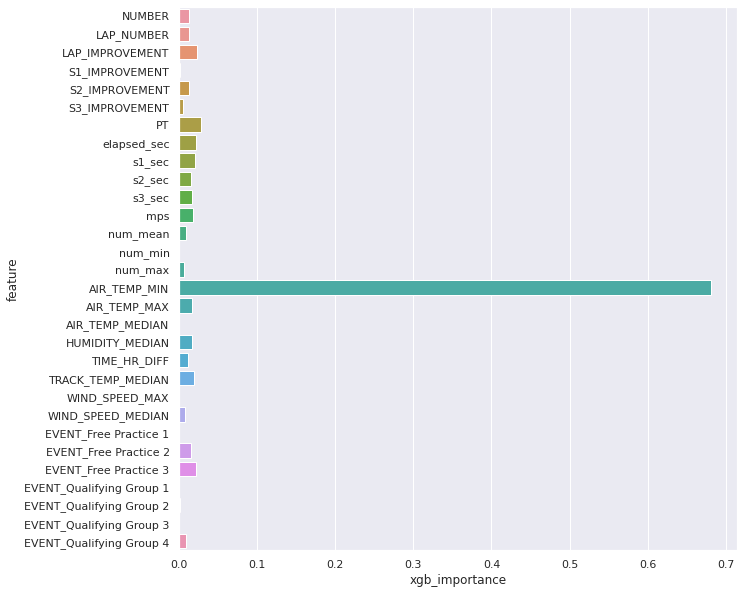

In [50]:
importance = model.feature_importances_
weights = pd.DataFrame()
weights['feature'] = input_cols
weights['xgb_importance'] = importance
sns.barplot(data=weights, y='feature', x='xgb_importance');

In [51]:
#predicting the test data
model = XGBRegressor()
model.fit(X,y)
predictions = model.predict(testData)
predictions.shape, test.shape

[07:00:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


((420,), (420, 25))

In [52]:
sub = pd.read_csv('submission.csv')
sub['LAP_TIME'] = predictions
sub.head()

,LAP_TIME
0,100.064713
1,96.900719
2,96.395889
3,100.064713
4,96.900719


In [ ]:
#making submission
sub.to_csv('predictions.csv', index=False)